In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

from sklearn.metrics import silhouette_score

from mpl_toolkits.mplot3d import Axes3D

# MAKE X AXIS INTEGERS
#from matplotlib.ticker import MaxNLocator
#plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


In [2]:
from subspace_clustering_helper_funcs import *

In [3]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [4]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

test_user_ids = ['P103', 'P109', 'P114', 'P124', 'P128', 'P004', 'P010']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [21]:
# Kai's laptop
#base_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\"
# BRC Desktop
base_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
#metadata_cols_df = pd.read_pickle(base_path+'metadata_cols_df.pkl')

num_rows_per_gesture = 64

## EMG Only: PCA 3D

In [23]:
print("Loading")
start_time = time.time()

data_path = base_path + "EMG_PCA3\\"

emg3_train_XY_df = pd.read_pickle(data_path+'emg_PCA3_training_u_df.pkl')
emg3_test_XY_df = pd.read_pickle(data_path+'emg_PCA3_test_users_df.pkl')
emg3_gesture_train_labels_df = emg3_train_XY_df[metadata_cols]
emg3_gesture_test_labels_df = emg3_test_XY_df[metadata_cols]
emg3_training_u_df = emg3_train_XY_df.drop(metadata_cols, axis=1)
emg3_test_users_df = emg3_test_XY_df.drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.19311165809631348s


In [24]:
print(emg3_train_XY_df.shape)
emg3_train_XY_df.head()

(327168, 6)


Participant Gesture_ID Gesture_Num         0         1         2
0        P102        pan           1 -0.027903  0.001411 -0.019509
1        P102        pan           1 -0.038982  0.006470 -0.000111
2        P102        pan           1 -0.116782  0.003824  0.011550
3        P102        pan           1 -0.030245 -0.017409  0.022540
4        P102        pan           1 -0.112950  0.026262  0.004837

In [25]:
print(emg3_training_u_df.shape)
emg3_training_u_df.head()

(327168, 3)


0         1         2
0 -0.027903  0.001411 -0.019509
1 -0.038982  0.006470 -0.000111
2 -0.116782  0.003824  0.011550
3 -0.030245 -0.017409  0.022540
4 -0.112950  0.026262  0.004837

In [26]:
print(emg3_gesture_train_labels_df.shape)
emg3_gesture_train_labels_df.head()

(327168, 3)


Participant Gesture_ID Gesture_Num
0        P102        pan           1
1        P102        pan           1
2        P102        pan           1
3        P102        pan           1
4        P102        pan           1

In [27]:
print(emg3_training_u_df.shape)
emg3_training_u_df.head()

(327168, 3)


0         1         2
0 -0.027903  0.001411 -0.019509
1 -0.038982  0.006470 -0.000111
2 -0.116782  0.003824  0.011550
3 -0.030245 -0.017409  0.022540
4 -0.112950  0.026262  0.004837

In [28]:
print(emg3_test_users_df.shape)
emg3_test_users_df.head()

(99584, 3)


0         1         2
11520  0.068817  0.042105 -0.044102
11521  0.074061  0.047283 -0.042408
11522  0.079972  0.043184 -0.055275
11523  0.066582  0.035923 -0.040610
11524  0.070243  0.048672 -0.050055

In [13]:
num_gestures = len(emg3_training_u_df) // num_rows_per_gesture
num_features = emg3_training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(emg3_training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
emg3_PCA_np = emg3_training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
emg3_flattened_PCA = emg3_PCA_np.reshape(num_gestures, -1)

Also, since this data is in 3D, let's go ahead and plot the PCA outputs directly to see if there are clear clusters in 3D

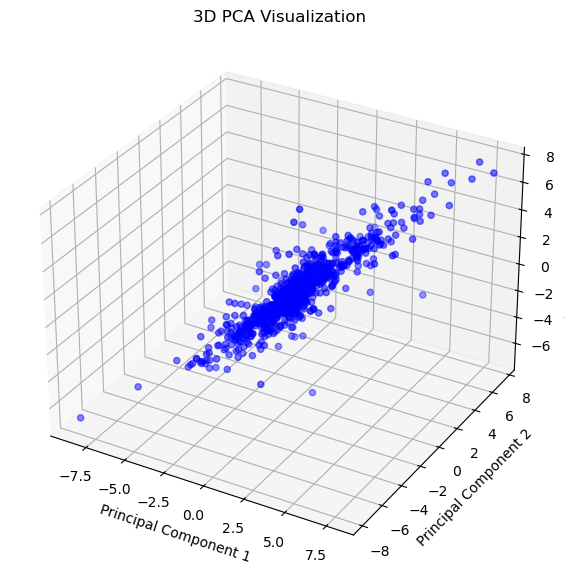

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(emg3_PCA_np[:, 0], emg3_PCA_np[:, 1], emg3_PCA_np[:, 2], c='b', marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization')

plt.show()

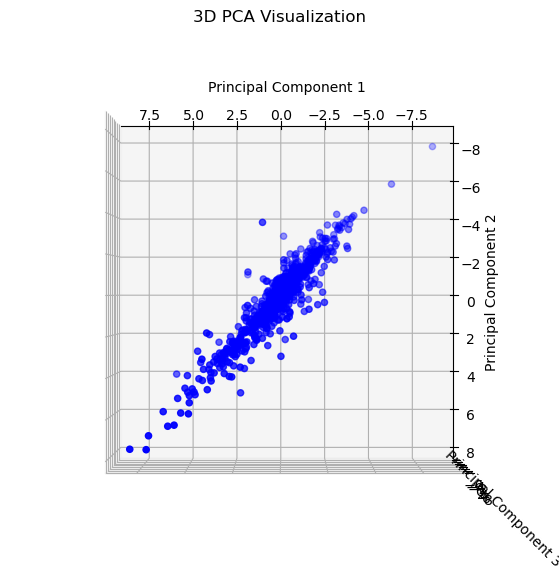

In [15]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(emg3_PCA_np[:, 0], emg3_PCA_np[:, 1], emg3_PCA_np[:, 2], c='b', marker='o')

# Setting labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization')

# Set the view angle
ax.view_init(elev=90, azim=90)  # Adjust elev and azim to change the view angle

plt.show()


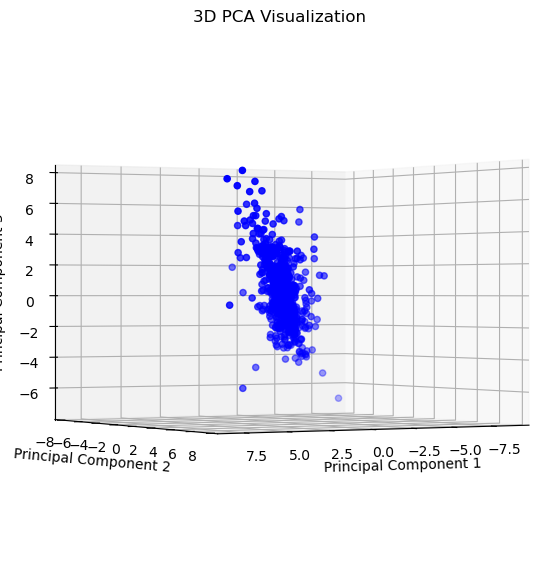

In [16]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(emg3_PCA_np[:, 0], emg3_PCA_np[:, 1], emg3_PCA_np[:, 2], c='b', marker='o')

# Setting labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization')

# Set the view angle
ax.view_init(elev=0, azim=60)  # Adjust elev and azim to change the view angle

plt.show()


## Plotting Aggregate Points (Eg One Point Per Gesture)

In [17]:
# Function to aggregate data
def aggregate_data(data, method='mean'):
    if method == 'mean':
        return np.mean(data, axis=1)
    elif method == 'median':
        return np.median(data, axis=1)
    elif method == 'max':
        return np.max(data, axis=1)
    elif method == 'min':
        return np.min(data, axis=1)
    elif method == 'norm':
        return np.linalg.norm(data, axis=1)
    else:
        raise ValueError("Invalid method. Choose from 'mean', 'median', 'max', 'min', 'norm'.")


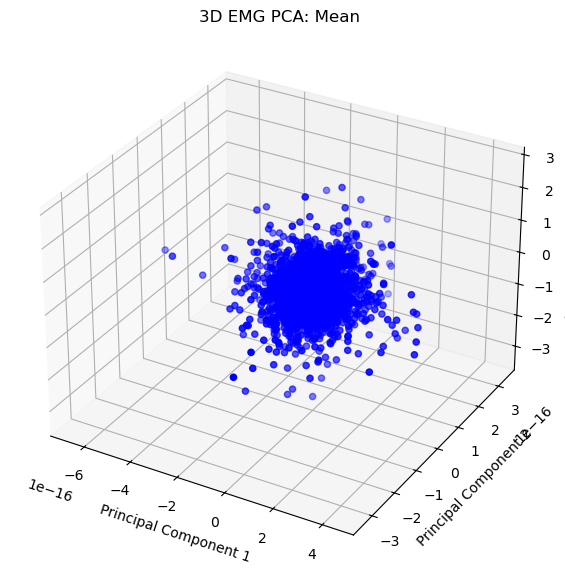

In [18]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
aggregated_data = aggregate_data(emg3_PCA_np, 'mean')
ax.scatter(aggregated_data[:, 0], aggregated_data[:, 1], aggregated_data[:, 2], c='b', marker='o')

# Setting labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D EMG PCA: Mean')

# Set the view angle
#ax.view_init(elev=0, azim=60)  # Adjust elev and azim to change the view angle

plt.show()


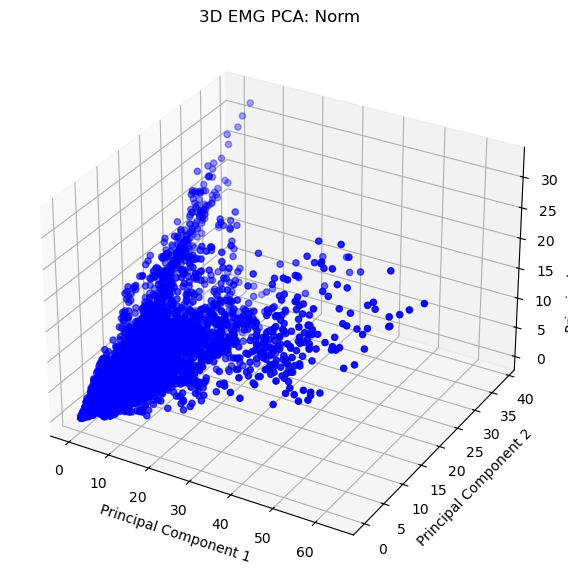

In [19]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
aggregated_data = aggregate_data(emg3_PCA_np, 'norm')
ax.scatter(aggregated_data[:, 0], aggregated_data[:, 1], aggregated_data[:, 2], c='b', marker='o')

# Setting labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D EMG PCA: Norm')

# Set the view angle
#ax.view_init(elev=0, azim=60)  # Adjust elev and azim to change the view angle

plt.show()


## Adding color labels based on xlsx quasi-ground truth

Actually reading in the xlsx as a dataframe:

In [20]:
# Read all sheets into a dictionary of dataframes
all_sheets_dict = pd.read_excel('C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\References\\user_gesture_descriptions_qualitative_analysis.xlsx', sheet_name=None)

# Initialize an empty list to hold individual dataframes
df_list = []

# Iterate through the dictionary and process each sheet
for user_id, df in all_sheets_dict.items():
    # Identify columns with "Unnamed" in their names
    unnamed_cols = df.columns.str.contains("Unnamed")
    # Drop those columns
    df = df.loc[:, ~unnamed_cols]
    
    df_list.append(df)  # Add the dataframe to the list


__NOTE THAT df_list[0] IS THE METADATA OF THE METADATA, SO IGNORE THIS DF!__

In [21]:
print(df_list[0].shape)
df_list[0].head()

(9, 16)


check gestures hand used             body part used intuitive?   
0            yes      left                    fingers        yes  \
1             no     right                   shoulder         no   
2      sometimes      both              wrist/forearm      maybe   
3            NaN      head  upper-body (bicep/tricep)        NaN   
4            NaN  shoulder                        NaN        NaN   

  arms off armrest? dynamic gesture?                                   rotate   
0               yes              yes                     supinate and pronate  \
1                no               no  rotate using  fingers muscles on table    
2            barely            maybe  rotate using  fingers muscles in midair   
3               NaN              NaN                        rotate from elbow   
4               NaN              NaN                    rotate from shoulders   

                                            move/pan   
0                   point and move entire hand in 3D  \
1  point and move entire hand in 2D (like on a fl...   
2                          move with two hands in 3D   
3  move with two hands in 2D (like on a flat surf...   
4                            tilt head to left/right   

                            select-single   
0                       point midair (3D)  \
1  point at table (like clicking a mouse)   
2           grab object and bring to self   
3                                     NaN   
4                                     NaN   

                                       zoom-in/out   
0  move two hands towards/away from center of body  \
1                one-handed pinch inwards/outwards   
2                  move head closer/away to screen   
3         pull object/screen closer/away from self   
4                                      turn a knob   

                                 duplicate                      delete   
0  do same gesture with one hand and other                  swipe away  \
1    click and click in different location               erase gesture   
2                            draw triangle  grab and pull towards self   
3                      clap hands together                   look down   
4                                      NaN        close hand into fist   

                                     open/close   
0                             move hand up/down  \
1                                         click   
2                                 select midair   
3                               open/close hand   
4  move both hands from center of body outwards   

                midair or on table                          gesture origin   
0                           midair                                  random  \
1                         on table                      tablet/touchscreen   
2                          neither                          computer/mouse   
3  on a 2D plane but not on table   make gestures as different as possible   
4                              NaN         what I can do with my abilities   

                               one hand vs two hands  
0                        what you would do on device  
1                         other hand is too disabled  
2                                  due to handedness  
3  one hand to minimize movement and decrease pai...  
4             use two hands for left and right click

Start with index 1 instead:

In [22]:
print(df_list[1].shape)
df_list[1].head()

(17, 17)


PID        gesture time   
0  P102         rotate    4  \
1  P102           move    2   
2  P102  select-single    3   
3  P102        zoom-in    2   
4  P102       zoom-out    5   

                                         description hand used   
0                rotate entire right hand from wrist     right  \
1  point right hand and move entire arm from left...     right   
2           point at object using right index finger     right   
3  use two hands to make a frame and move hands c...      both   
4  use right thumb and index finger and pinch fin...     right   

  lifted arms off arm rest? dynamic gesture? muscles activated 1   
0                       yes              yes       wrist/forearm  \
1                       yes              yes            shoulder   
2                       yes              yes            shoulder   
3                       yes              yes            shoulder   
4                       yes              yes             fingers   

         muscles activated 2 muscles activated 3   
0                   shoulder             fingers  \
1  upper-body (bicep/tricep)             fingers   
2  upper-body (bicep/tricep)             fingers   
3  upper-body (bicep/tricep)             fingers   
4              wrist/forearm                 NaN   

                                         agreement midair or on table   
0                             supinate and pronate             midair  \
1                 point and move entire hand in 3D             midair   
2                                point midair (3D)             midair   
3  move two hands towards/away from center of body             midair   
4                one-handed pinch inwards/outwards             midair   

  gesture ideas origin 1  gesture ideas origin 2  gesture ideas origin 3   
0     tablet/touchscreen                     NaN                     NaN  \
1                    NaN                     NaN                     NaN   
2                    NaN                     NaN                     NaN   
3                    NaN                     NaN                     NaN   
4                    NaN                     NaN                     NaN   

  one hand v 2 hands        one hand v 2 hands.1  
0  due to handedness  other hand is too disabled  
1                NaN                         NaN  
2                NaN                         NaN  
3                NaN                         NaN  
4                NaN                         NaN

Columns we care about for clustering:
- hand used
- lifted arms off arm rest?
- muscles activated 1 (parse to break up slashes?)

I think it makes the most sense to ignore gesture number, then match based on PID (Participant) and gesture (Gesture_ID). Note that since the full dataset has 64 rows per gesture, each label will be repeated 64 times in a row (at least in the way that it is currently formatted...)

In [23]:
# Concatenate all DataFrames in the list into one large DataFrame
all_PID_xlsx_df = pd.concat(df_list[1:], ignore_index=True)
# Optionally, reset the index if needed
all_PID_xlsx_df.reset_index(drop=True, inplace=True)
all_PID_xlsx_df.rename(columns={'PID': 'Participant', 'gesture': 'Gesture_ID', 'hand used': 'Handedness'}, inplace=True)

print(all_PID_xlsx_df.shape)
all_PID_xlsx_df.head()

(477, 22)


Participant     Gesture_ID time   
0        P102         rotate    4  \
1        P102           move    2   
2        P102  select-single    3   
3        P102        zoom-in    2   
4        P102       zoom-out    5   

                                         description Handedness   
0                rotate entire right hand from wrist      right  \
1  point right hand and move entire arm from left...      right   
2           point at object using right index finger      right   
3  use two hands to make a frame and move hands c...       both   
4  use right thumb and index finger and pinch fin...      right   

  lifted arms off arm rest? dynamic gesture? muscles activated 1   
0                       yes              yes       wrist/forearm  \
1                       yes              yes            shoulder   
2                       yes              yes            shoulder   
3                       yes              yes            shoulder   
4                       yes              yes             fingers   

         muscles activated 2 muscles activated 3  ... gesture ideas origin 1   
0                   shoulder             fingers  ...     tablet/touchscreen  \
1  upper-body (bicep/tricep)             fingers  ...                    NaN   
2  upper-body (bicep/tricep)             fingers  ...                    NaN   
3  upper-body (bicep/tricep)             fingers  ...                    NaN   
4              wrist/forearm                 NaN  ...                    NaN   

  gesture ideas origin 2 gesture ideas origin 3 one hand v 2 hands   
0                    NaN                    NaN  due to handedness  \
1                    NaN                    NaN                NaN   
2                    NaN                    NaN                NaN   
3                    NaN                    NaN                NaN   
4                    NaN                    NaN                NaN   

         one hand v 2 hands.1 notes muscles activated 4 body part used 1   
0  other hand is too disabled   NaN                 NaN              NaN  \
1                         NaN   NaN                 NaN              NaN   
2                         NaN   NaN                 NaN              NaN   
3                         NaN   NaN                 NaN              NaN   
4                         NaN   NaN                 NaN              NaN   

  body part used 2 body part used 3  
0              NaN              NaN  
1              NaN              NaN  
2              NaN              NaN  
3              NaN              NaN  
4              NaN              NaN  

[5 rows x 22 columns]

In [24]:
full_metadata_df = pd.merge(metadata_training_df, all_PID_xlsx_df, on=['Participant', 'Gesture_ID'], how='left')
print(full_metadata_df.shape)
full_metadata_df.head()

(327168, 23)


Participant Gesture_ID Gesture_Num time   
0        P102        pan           1    3  \
1        P102        pan           1    3   
2        P102        pan           1    3   
3        P102        pan           1    3   
4        P102        pan           1    3   

                                         description Handedness   
0  point right hand and move entire arm from left...      right  \
1  point right hand and move entire arm from left...      right   
2  point right hand and move entire arm from left...      right   
3  point right hand and move entire arm from left...      right   
4  point right hand and move entire arm from left...      right   

  lifted arms off arm rest? dynamic gesture? muscles activated 1   
0                       yes              yes            shoulder  \
1                       yes              yes            shoulder   
2                       yes              yes            shoulder   
3                       yes              yes            shoulder   
4                       yes              yes            shoulder   

         muscles activated 2  ... gesture ideas origin 1   
0  upper-body (bicep/tricep)  ...                    NaN  \
1  upper-body (bicep/tricep)  ...                    NaN   
2  upper-body (bicep/tricep)  ...                    NaN   
3  upper-body (bicep/tricep)  ...                    NaN   
4  upper-body (bicep/tricep)  ...                    NaN   

  gesture ideas origin 2 gesture ideas origin 3 one hand v 2 hands   
0                    NaN                    NaN                NaN  \
1                    NaN                    NaN                NaN   
2                    NaN                    NaN                NaN   
3                    NaN                    NaN                NaN   
4                    NaN                    NaN                NaN   

  one hand v 2 hands.1 notes muscles activated 4 body part used 1   
0                  NaN   NaN                 NaN              NaN  \
1                  NaN   NaN                 NaN              NaN   
2                  NaN   NaN                 NaN              NaN   
3                  NaN   NaN                 NaN              NaN   
4                  NaN   NaN                 NaN              NaN   

  body part used 2 body part used 3  
0              NaN              NaN  
1              NaN              NaN  
2              NaN              NaN  
3              NaN              NaN  
4              NaN              NaN  

[5 rows x 23 columns]

In [25]:
full_metadata_df.columns

Index(['Participant', 'Gesture_ID', 'Gesture_Num', 'time', 'description',
       'Handedness', 'lifted arms off arm rest?', 'dynamic gesture?',
       'muscles activated 1', 'muscles activated 2', 'muscles activated 3',
       'agreement', 'midair or on table', 'gesture ideas origin 1',
       'gesture ideas origin 2', 'gesture ideas origin 3',
       'one hand v 2 hands', 'one hand v 2 hands.1', 'notes',
       'muscles activated 4', 'body part used 1', 'body part used 2',
       'body part used 3'],
      dtype='object')

In [62]:
# Define a color map for Handedness
color_map = {
    'right': 'blue',
    'left': 'orange',
    'both': 'purple'
}

In [66]:
# Get the colors for each data point
colors = full_metadata_df['Handedness'].apply(lambda x: color_map.get(x, 'red')).values
colors = colors.reshape(emg3_PCA_np.shape[0], emg3_PCA_np.shape[1], -1)
colors_per_gesture = np.squeeze(colors[:,0,:])  # Squeze to make it 1D

In [67]:
emg3_PCA_np.shape

(5112, 64, 3)

In [68]:
colors_per_gesture.shape

(5112,)

In [78]:
full_metadata_df.shape

(327168, 23)

Checking NANs..

In [82]:
# Print the counts for each unique entry in the 'Handedness' column
handedness_counts = full_metadata_df['Handedness'].value_counts()
print("Handedness counts:")
print(handedness_counts)

print()

# Count the number of NaNs in the 'Handedness' column
nans_count = full_metadata_df['Handedness'].isna().sum()
# Print the count of NaNs
print(f"NaNs: {nans_count}")

Handedness counts:
Handedness
right    5760
both      640
Name: count, dtype: int64

NaNs: 320768


In [72]:
# Print the counts for each color
unique_colors, counts = np.unique(colors, return_counts=True)
for color, count in zip(unique_colors, counts):
    print(f"{color}: {count}")

blue: 5760
purple: 640
red: 320768


Clearly, colors is not getting applied correctly...

In [69]:
# Print the counts for each color
unique_colors, counts = np.unique(colors, return_counts=True)
for color, count in zip(unique_colors, counts):
    print(f"{color}: {count}")

blue: 90
purple: 10
red: 5012


In [77]:
emg3_PCA_np.shape

(5112, 64, 3)

In [75]:
aggregated_data = aggregate_data(emg3_PCA_np, 'mean')
print(aggregated_data.shape)

(5112, 3)


Checkig total NANs in original xlsx df (which is by gesture)

In [ ]:
total_nans = 0
total_gestures = 0

for idx, df in enumerate(df_list[1:]):
    nans_count = df['hand used'].isna().sum()
    print(f"DF{idx+1} NaNs: {nans_count}")
    total_nans += nans_count
    total_gestures += df.shape[0]

print(f"\n{total_nans} Total NANs in {total_gestures} gestures")

Apply color map and merging directly to original xlsx df?

Making the 3D colored plot...

In [91]:
# Get the colors for each data point
colors = full_metadata_df['Handedness'].apply(lambda x: color_map.get(x, 'red')).values
colors = colors.reshape(emg3_PCA_np.shape[0], emg3_PCA_np.shape[1], -1)
colors_per_gesture = np.squeeze(colors[:,0,:])  # Squeze to make it 1D

In [92]:
# Print the counts for each color
unique_colors, counts = np.unique(colors, return_counts=True)
for color, count in zip(unique_colors, counts):
    print(f"{color}: {count}")

blue: 5760
purple: 640
red: 320768


Why is there such a massive discrepancy? Metadata labels are on a per gesture basis. colors_per_gesture gets condensed... something there? So much red is a massive issue though

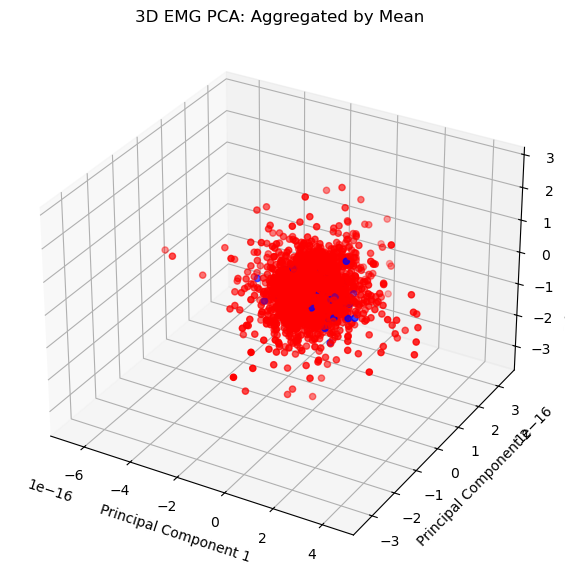

In [93]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(aggregated_data[:, 0], aggregated_data[:, 1], aggregated_data[:, 2], c=colors_per_gesture, marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D EMG PCA: Aggregated by Mean')

# Set the view angle (optional)
# ax.view_init(elev=0, azim=60)  # Adjust elev and azim to change the view angle

plt.show()